In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ruta_Normalizado = '/content/drive/MyDrive/TFM/Google_Colab/TFM_dataset_imagenes/Datasets/Normalizado'


# Import

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from sklearn.utils import shuffle
from keras.models import load_model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2


import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Def

## Convertir a imagen

In [12]:
def convertir1D(data):
  dataset = []
  for fila in data:
    data_reshape =fila.reshape(40,40)
    dataset.append(data_reshape)

  dataset = np.array(dataset)
  return dataset

In [20]:
# Train
def convertir3D(x_train, x_test):
  print(f'x_train = {x_train.shape}')
  x_train_3D = convertir_a_imagenes(x_train)
  print(f'x_train_3D matriz = {x_train_3D.shape}')

  # Test
  print(f'x_test = {x_test.shape}')
  x_test_3D = convertir_a_imagenes(x_test)
  print(f'x_test_3D matriz = {x_test_3D.shape}')

  return x_train_3D, x_test_3D


### funciones convertir a imagen

In [14]:
def mean(data, no_elements):  # Toma dos argumentos: un conjunto de datos y un número de elementos.
    X = np.zeros((data.shape[0], data.shape[1]))  # Creamos una matriz de ceros con la misma forma que los datos de entrada.
    for i in range(data.shape[1] - no_elements + 1):  # En las últimas filas no se calcula la media, quedaran no_elements -1 filas de ceros al final
        X[:, i] = np.mean(data[:, i:i + no_elements], axis=1)  # asignamos a la columna i-ésima de X la media de la submatriz de los datos que va desde la columna i hasta la columna i + no_elements, a lo largo del eje 1 (columnas).
    return X.astype(np.float16)  # Finalmente, convertimos los valores en la matriz X a float16 para ahorrar memoria y la retornamos.

def median(data, no_elements):
    X = np.zeros((data.shape[0], data.shape[1]))
    for i in range(data.shape[1] - no_elements + 1):
        X[:, i] = np.median(data[:, i:i + no_elements], axis=1)
    return X.astype(np.float16)

def sig_image(data, size):  # Toma dos argumentos: un conjunto de datos y un tamaño.
    X = np.zeros((data.shape[0], size, size))  # Creamos una matriz de ceros con la forma especificada: número de filas en los datos y tamaño dado al cuadrado.
    for i in range(data.shape[0]):  # Para cada índice desde 0 hasta el número de filas en los datos,
        X[i] = (data[i, :].reshape(size, size))  # asignamos a la i-ésima entrada de X los datos en la fila i, reorganizados como una matriz de tamaño size x size.
    return X.astype(np.float16)  # Finalmente, convertimos los valores en la matriz X a float16 para ahorrar memoria y la retornamos.

def convertir_a_imagenes(dataset):
    channel_mean = (mean(dataset, 10)).astype(np.float16)
    # Esto calculará la media en ventanas de tamaño 10 a lo largo de cada columna en 'x'.

    x_mean = sig_image(channel_mean, 40)
    # Esta función remodelará cada fila en 'channel_mean' en una imagen de 40x40.

    channel_median = (median(dataset, 10)).astype(np.float16)
    # Esto calculará la mediana en ventanas de tamaño 10 a lo largo de cada columna en 'x'.

    x_md = sig_image(dataset, 40)
    # Esta función remodelará cada fila en 'x' en una imagen de 40x40.

    x_n=sig_image(dataset,40)

    # np.stack() en Numpy se utiliza para unir un secuencia de arrays a lo largo de un nuevo eje.
    X=np.stack((x_n,x_mean,x_md),axis=1).astype(np.float16)

    # En Keras, los canales van al final
    X = X.transpose(0, 2, 3, 1)

    return X


## Entrenamiento + graficar

### Entrenamiento

In [39]:
def entrenamiento(x, y, patience):

  epochs = 2000
  metrica_parar = 'val_accuracy'

  x_train, x_train_val, y_train, y_train_val = train_test_split(x, y, test_size=0.2, random_state=20)
  print(x_train.shape)
  print(y_train.shape)
  print(x_train_val.shape)
  print(y_train_val.shape)

  #Callback
  #########

  # EarlyStop si durante x epoch no se consigue ninguna mejora en accuracy
  early_stopping = EarlyStopping(monitor=metrica_parar, patience=patience)

  #Imprimir mensaje indicando que no se han conseguido mejoras durante X epoch.
  class ImprimirMensajeCallback(Callback):
      def on_train_begin(self, logs=None):
          self.stopped_epoch = 0

      def on_epoch_end(self, epoch, logs=None):
          if self.model.stop_training:
             self.stopped_epoch = epoch
             print(f"El entrenamiento ha sido detenido en el epoch {self.stopped_epoch + 1}. Loss no ha mejorado durante {patience} epoch.")

  # ModelCheckpoint para guardar el mejor modelo
  checkpoint = ModelCheckpoint(
      'modelos/mejor_modelo.h5',  # Ruta relativa al archivo
      monitor=metrica_parar,
      save_best_only=True,
      mode='max',
      verbose=1
  )

  # Modelo
  ########

  # Creación del modelo
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='LeakyReLU', input_shape=(40, 40, 3)))
  model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
  model.add(Conv2D(64, kernel_size=(4, 4), strides=(1, 1), activation='LeakyReLU'))
  model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='LeakyReLU', kernel_regularizer=l2(0.01)))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))

  # Compilación del modelo
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  mi_callback = ImprimirMensajeCallback()

  # Entrenamiento del modelo
  history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, verbose=1, validation_data=(x_train_val, y_train_val), callbacks=[early_stopping, mi_callback, checkpoint])

  epoch_donde_se_detuvo = mi_callback.stopped_epoch

  # mejor_modelo = load_model('modelos/mejor_modelo.h5')


  print('********VALIDACIÓN***********')

  mejor_modelo = load_model('modelos/mejor_modelo.h5')

  val_loss, val_acc = mejor_modelo.evaluate(x_train_val, y_train_val, verbose=1)

  print('Resultados del val:')
  print('\nval accuracy:', val_acc)
  print('val loss:', val_loss)

  # Crear una gráfica con los datos del DataFrame
  pd.DataFrame(history.history).plot(
    figsize=(20,5),   # Tamaño de la gráfica
    # xlim=[0,epoch_donde_se_detuvo],     # Límites del eje X
    ylim=[0,1.5],      # Límites del eje Y
    grid=True,       # Mostrar cuadrícula en la gráfica
    xlabel='Epoch',  # Etiqueta del eje X
    style=['r--','r-']  # Estilo de línea de cada columna
  )
  # Mostrar la gráfica
  ####################
  plt.show()

  # print('********************')
  # acc = history.history['accuracy']
  # ult_acc = acc[-patience-1:]
  # print('Train accuracy: ', ult_acc)

  # loss = history.history['loss']
  # ult_loss = loss[-patience-1:]
  # print('Train loss: ', ult_loss)

In [37]:
def test_modelo(x_test, y_test, ntest):

  x_test_shuffle, y_test_shuffle = shuffle(x_test, y_test, random_state=42)
  x_test = x_test_shuffle[:ntest]
  y_test = y_test_shuffle[:ntest]

  print(f'Nº de muestras para el test: {x_test.shape}')

  #Test
  ######

  # Cargar el mejor modelo guardado
  mejor_modelo = load_model('modelos/mejor_modelo.h5')

  test_loss, test_acc = mejor_modelo.evaluate(x_test, y_test, verbose=0)

  print('*******************')
  print('Resultados del test:')
  print('\nTest accuracy:', test_acc)
  print('Test loss:', test_loss)

  # Obtener las predicciones del modelo en el conjunto de prueba
  y_pred = mejor_modelo.predict(x_test)
  y_pred_labels = np.argmax(y_pred, axis=1)  # Obtener las etiquetas predichas

  # Calcular la matriz de confusión
  conf_matrix = confusion_matrix(y_test, y_pred_labels)

  # Crear una figura para la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title('Matriz de Confusión')
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Real')
  plt.show()

  # Calcular los porcentajes de acierto por etiqueta
  row_sums = conf_matrix.sum(axis=1, keepdims=True)
  conf_matrix_percent = conf_matrix / row_sums

  # Crear una figura para la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False)
  plt.title('Matriz de Confusión (Porcentaje de Acierto)')
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Real')
  plt.show()

# Normalizado

## Normalizado

In [40]:
# Cargar datasets
x_train =np.load(f'{ruta_Normalizado}/x_train_Normalizado.npy')
y_train =np.load(f'{ruta_Normalizado}/y_train_Normalizado.npy')

x_test = np.load(f'{ruta_Normalizado}/x_test_Normalizado.npy')
y_test = np.load(f'{ruta_Normalizado}/y_test_Normalizado.npy')

# Convertir a 3D
x_train, x_test = convertir3D(x_train, x_test)

x_train = (2240, 1600)
x_train_3D matriz = (2240, 40, 40, 3)
x_test = (560, 1600)
x_test_3D matriz = (560, 40, 40, 3)


(1792, 40, 40, 3)
(1792,)
(448, 40, 40, 3)
(448,)
Epoch 1/2000
 6/14 [===========>..................] - ETA: 0s - loss: 6.9386 - accuracy: 0.1055 

11/14 [======================>.......] - ETA: 0s - loss: 6.8493 - accuracy: 0.1058
Epoch 1: val_accuracy improved from -inf to 0.08705, saving model to modelos/mejor_modelo.h5
14/14 [==============================] - 3s 34ms/step - loss: 6.7992 - accuracy: 0.1083 - val_loss: 6.5875 - val_accuracy: 0.0871
Epoch 2/2000
10/14 [====================>.........] - ETA: 0s - loss: 6.4455 - accuracy: 0.1391
Epoch 2: val_accuracy improved from 0.08705 to 0.08929, saving model to modelos/mejor_modelo.h5
14/14 [==============================] - 0s 19ms/step - loss: 6.3818 - accuracy: 0.1451 - val_loss: 6.1930 - val_accuracy: 0.0893
Epoch 3/2000
11/14 [======================>.......] - ETA: 0s - loss: 6.0225 - accuracy: 0.1570
Epoch 3: val_accuracy improved from 0.08929 to 0.20312, saving model to modelos/mejor_modelo.h5
14/14 [==============================] - 0s 17ms/step - loss: 5.9843 - accuracy: 0.1641 - val_loss: 5.7989 - val_accuracy: 0.2031
Epoch 4/2000
13/14 [==========================>...

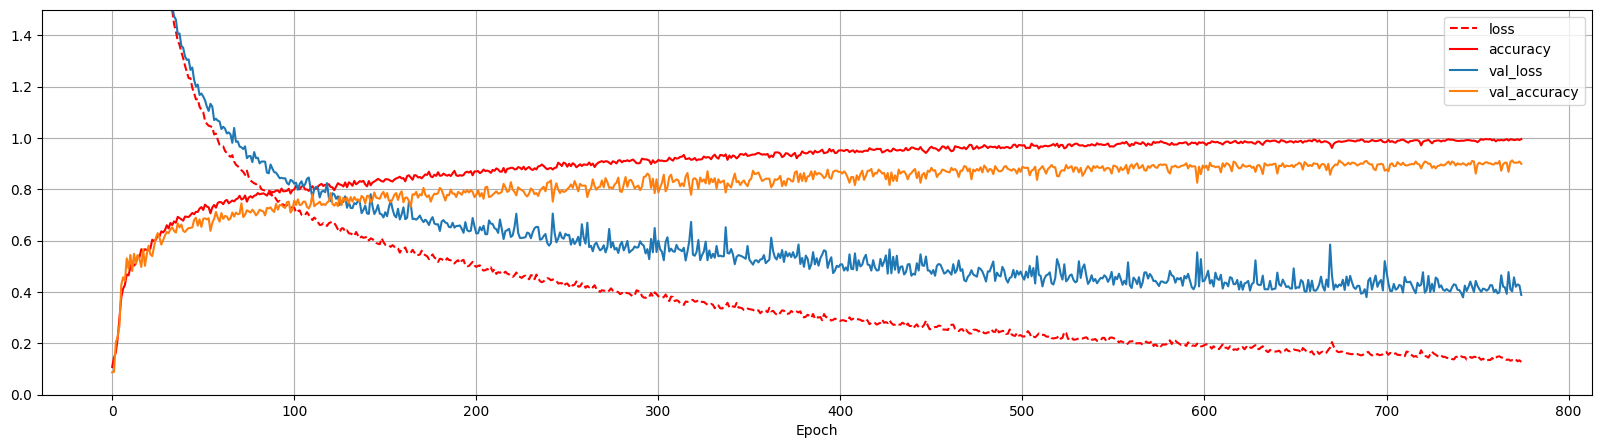

In [42]:
entrenamiento(x_train, y_train, 100)

Nº de muestras para el test: (560, 40, 40, 3)
*******************
Resultados del test:

Test accuracy: 0.8964285850524902
Test loss: 0.33643606305122375
18/18 [==============================] - 0s 2ms/step


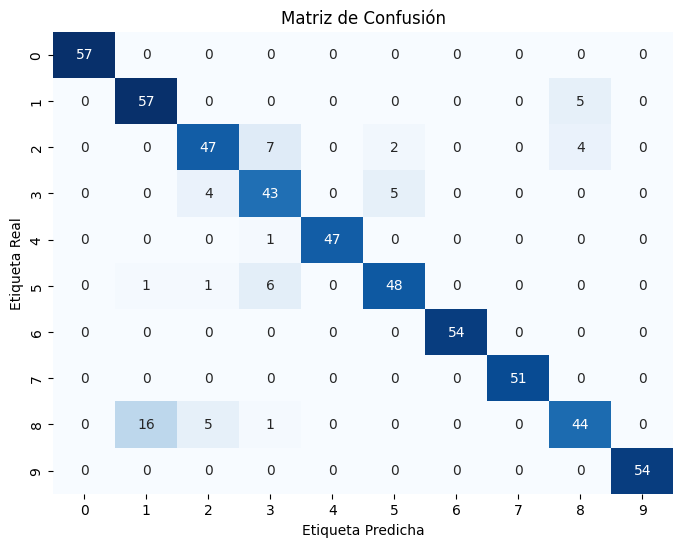

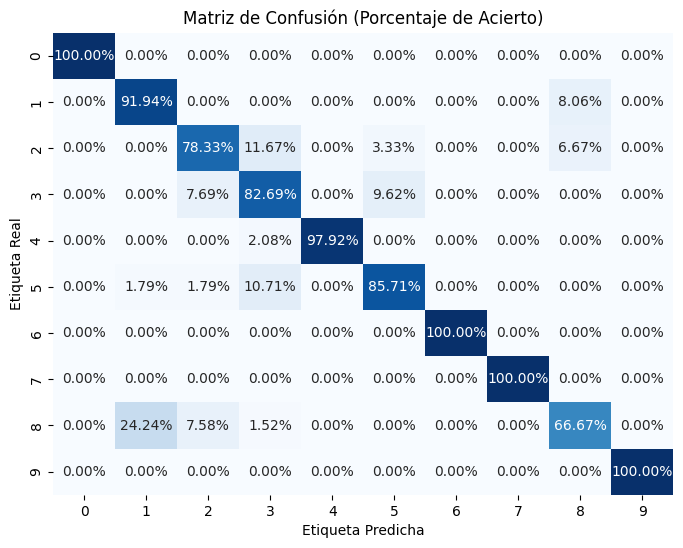

In [43]:
test_modelo(x_test, y_test, 560)

## Normalizado 1D

In [30]:
# x_train_1D = imagen1D(x_train)
# x_test_1D = imagen1D(x_test)


# entrenamiento_grafica(x_train_1D, y_train, x_test_1D, y_test, 560, 200)

## Normalizado desbalanceado

x_train = (380, 1600)
x_train_3D matriz = (380, 40, 40, 3)
x_test = (560, 1600)
x_test_3D matriz = (560, 40, 40, 3)
(304, 40, 40, 3)
(304,)
(76, 40, 40, 3)
(76,)
Nº de muestras para el test: (560, 40, 40, 3)
Epoch 1/2000
3/3 [==============================] - 2s 246ms/step - loss: 6.9886 - accuracy: 0.2533 - val_loss: 6.8781 - val_accuracy: 0.4342
Epoch 2/2000
3/3 [==============================] - 0s 32ms/step - loss: 6.8038 - accuracy: 0.5493 - val_loss: 6.7440 - val_accuracy: 0.4342
Epoch 3/2000
3/3 [==============================] - 0s 33ms/step - loss: 6.6301 - accuracy: 0.5493 - val_loss: 6.6386 - val_accuracy: 0.4342
Epoch 4/2000
3/3 [==============================] - 0s 31ms/step - loss: 6.4915 - accuracy: 0.5493 - val_loss: 6.5727 - val_accuracy: 0.4342
Epoch 5/2000
3/3 [==============================] - 0s 35ms/step - loss: 6.3631 - accuracy: 0.5493 - val_loss: 6.5267 - val_accuracy: 0.4342
Epoch 6/2000
3/3 [==============================] - 0s 30ms/step - loss: 6.2545 - accu

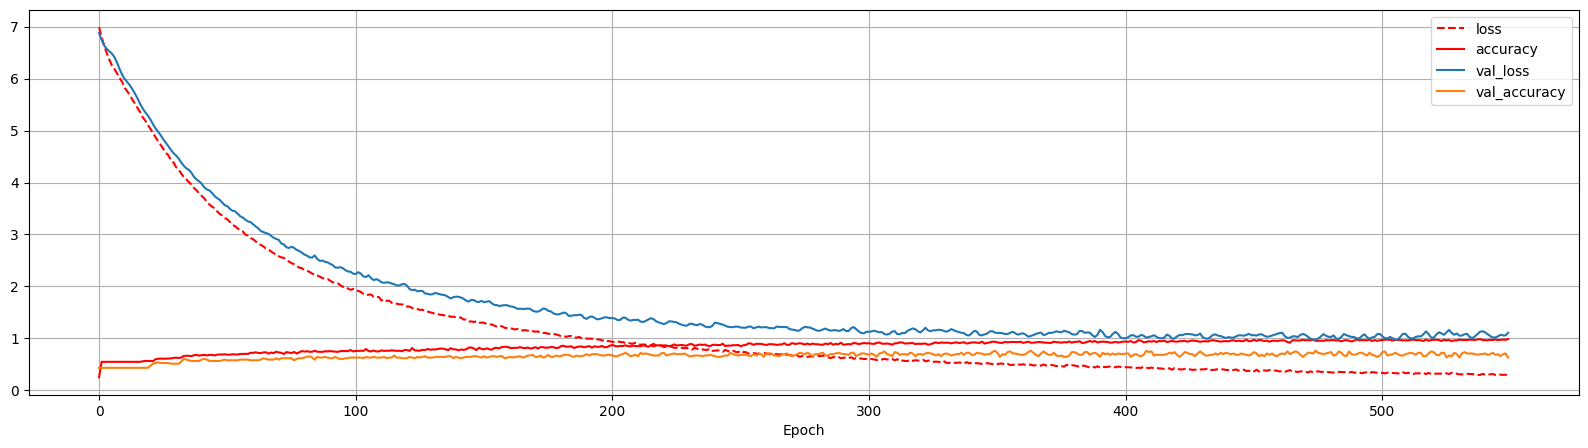

********************
Train accuracy:  [0.9342105388641357, 0.9243420958518982, 0.9144737124443054, 0.9144737124443054, 0.9342105388641357, 0.9243420958518982, 0.9309210777282715, 0.9309210777282715, 0.9309210777282715, 0.9276315569877625, 0.9375, 0.9144737124443054, 0.9243420958518982, 0.9375, 0.9177631735801697, 0.9177631735801697, 0.9243420958518982, 0.9309210777282715, 0.9276315569877625, 0.9210526347160339, 0.9177631735801697, 0.9144737124443054, 0.9144737124443054, 0.9375, 0.9276315569877625, 0.9243420958518982, 0.9177631735801697, 0.9276315569877625, 0.9243420958518982, 0.9407894611358643, 0.9177631735801697, 0.9342105388641357, 0.9342105388641357, 0.9473684430122375, 0.9111841917037964, 0.9177631735801697, 0.9342105388641357, 0.9506579041481018, 0.9342105388641357, 0.9506579041481018, 0.9210526347160339, 0.9342105388641357, 0.9375, 0.9342105388641357, 0.9309210777282715, 0.9177631735801697, 0.9210526347160339, 0.9342105388641357, 0.9210526347160339, 0.9276315569877625, 0.9375, 0

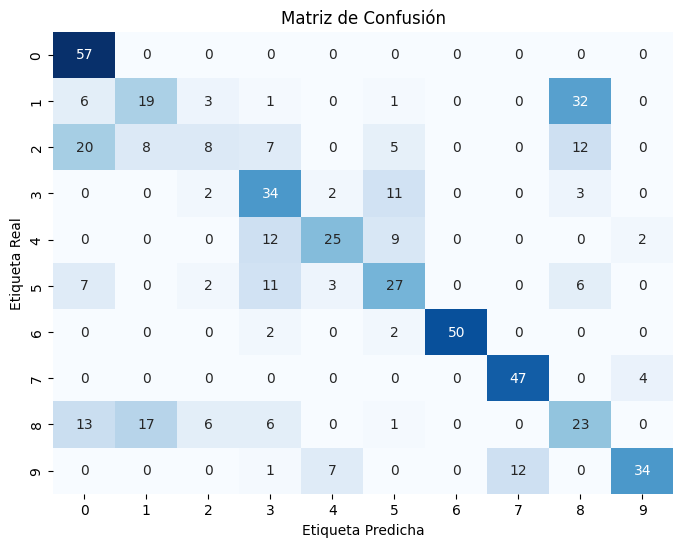

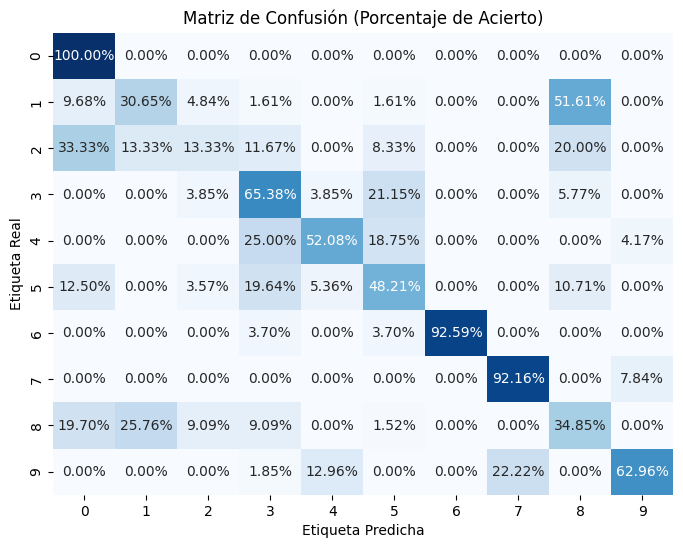

In [16]:
x_train =np.load(f'{ruta_Normalizado}/x_train_Normalizado_desbalanceado.npy')
y_train =np.load(f'{ruta_Normalizado}/y_train_Normalizado_desbalanceado.npy')

x_test = np.load(f'{ruta_Normalizado}/x_test_Normalizado.npy')
y_test = np.load(f'{ruta_Normalizado}/y_test_Normalizado.npy')

entrenamiento(x_train, y_train, x_test, y_test, 560, 200)

# Normalizado generado

x_train = (2000, 1600)
x_train_3D matriz = (2000, 40, 40, 3)
x_test = (560, 1600)
x_test_3D matriz = (560, 40, 40, 3)
(1600, 40, 40, 3)
(1600,)
(400, 40, 40, 3)
(400,)
Nº de muestras para el test: (20, 40, 40, 3)
Epoch 1/2000
13/13 [==============================] - 2s 35ms/step - loss: 6.8444 - accuracy: 0.0988 - val_loss: 6.5964 - val_accuracy: 0.1450
Epoch 2/2000
13/13 [==============================] - 0s 14ms/step - loss: 6.4441 - accuracy: 0.1713 - val_loss: 6.2143 - val_accuracy: 0.2050
Epoch 3/2000
13/13 [==============================] - 0s 13ms/step - loss: 6.0592 - accuracy: 0.1937 - val_loss: 5.8319 - val_accuracy: 0.2150
Epoch 4/2000
13/13 [==============================] - 0s 13ms/step - loss: 5.6799 - accuracy: 0.2300 - val_loss: 5.4534 - val_accuracy: 0.2525
Epoch 5/2000
13/13 [==============================] - 0s 13ms/step - loss: 5.3032 - accuracy: 0.2881 - val_loss: 5.0856 - val_accuracy: 0.3475
Epoch 6/2000
13/13 [==============================] - 0s 11ms/step - los

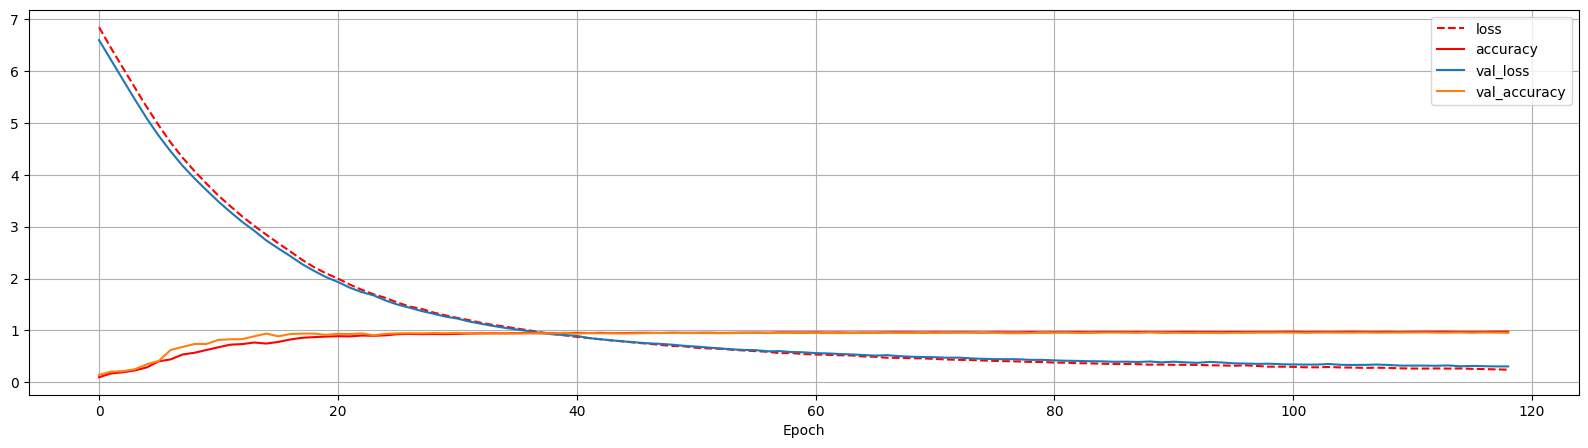

********************
Train accuracy:  [0.96875, 0.9643750190734863, 0.96875, 0.9706249833106995, 0.9674999713897705, 0.96875, 0.9668750166893005, 0.9712499976158142, 0.9674999713897705, 0.9693750143051147, 0.96875, 0.971875011920929, 0.9756249785423279, 0.9681249856948853, 0.971875011920929, 0.9693750143051147, 0.9706249833106995, 0.9750000238418579, 0.9706249833106995, 0.9693750143051147, 0.9725000262260437, 0.96875, 0.9731249809265137, 0.9762499928474426, 0.9743750095367432, 0.9750000238418579, 0.9712499976158142, 0.9700000286102295, 0.971875011920929, 0.9756249785423279, 0.9750000238418579]
Train loss:  [0.340922087430954, 0.34254035353660583, 0.3381509780883789, 0.33832308650016785, 0.33567485213279724, 0.32869061827659607, 0.3262055218219757, 0.3195132613182068, 0.3276435136795044, 0.31460899114608765, 0.3021605610847473, 0.301697701215744, 0.29807010293006897, 0.2905486524105072, 0.2896132171154022, 0.2958427667617798, 0.2870451509952545, 0.2842661738395691, 0.27890777587890625, 

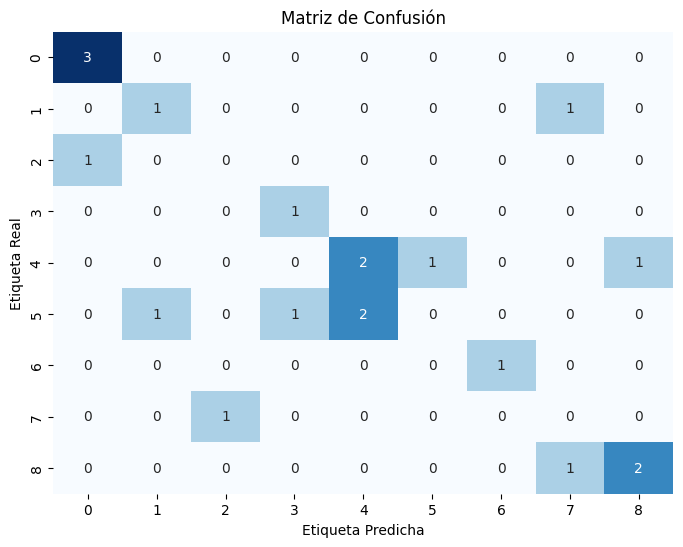

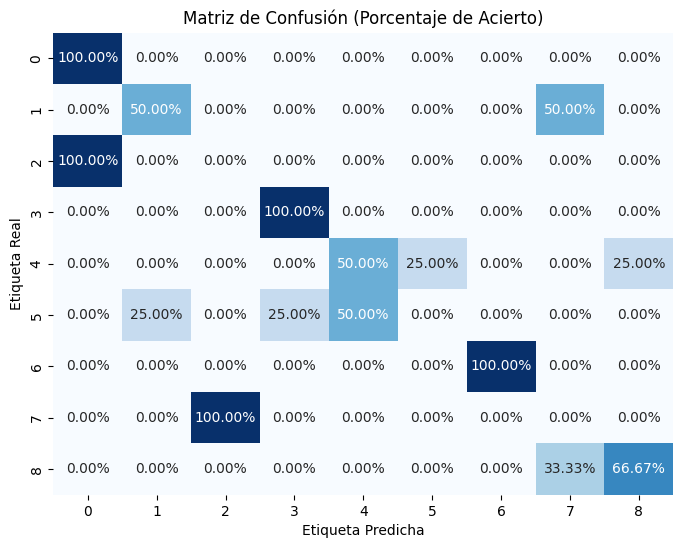

In [19]:
x_train =np.load(f'{ruta_Normalizado}/x_train_generado_180.npy')
y_train =np.load(f'{ruta_Normalizado}/y_train_generado_180.npy')

x_test = np.load(f'{ruta_Normalizado}/x_test_Normalizado.npy')
y_test = np.load(f'{ruta_Normalizado}/y_test_Normalizado.npy')

entrenamiento(x_train, y_train, x_test, y_test, 20, 30)